In [1]:
"""
    Experimentation with RFC on a datset of MRI covid/non-covid images.
    
    Created: 11/25/2020
    Author(s): Akarsh V Hebbar (ah67805)

"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *

from DataHandler import dataHandler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import FastICA

In [2]:
dh = dataHandler() # data handler object. See DataHandler.py for more information.

# ALTER HYPERPARAMETERS HERE
BATCH_SIZE = 16




In [3]:
dataset = dh.get_all_data_labeled(shuffle=True)

In [4]:
# check that all data is in place
assert len(dh.get_non_covid_data_fp()) == 397 and len(dh.get_covid_data_fp()) == 349 and len(dh.get_all_data_labeled()) == (397 + 349)

In [5]:
datapoint = dataset[0] # get some datapoint from the dataset
random_img = cv2.imread(datapoint[0])

Label:  0.0
filepath:  /Users/benflanders/Documents/github/COVID-19-CT-image-analysis-CSCI_8955/data/CT_NonCOVID/22%0.jpg
image dimensions:  (246, 364, 3)
image datatype:  uint8
image max:  255
image min


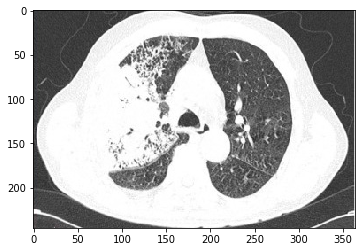

In [6]:
print("Label: ", datapoint[1])
print("filepath: ", datapoint[0])
print("image dimensions: ", random_img.shape)
print("image datatype: ", random_img.dtype)
print("image max: ", random_img.max())
print("image min")
plt.imshow(random_img)

In [7]:
random_img.shape

(246, 364, 3)

In [8]:
# split the dataset into a train and test dataset

split_point = int(len(dataset) * .8 ) # 80 / 20 split

train_data = dataset[0:split_point]
test_data = dataset[split_point:]

assert len(train_data) + len(test_data) == (397 + 349) # ensure all expected data is present

In [9]:
# get the image data and load it into memory

#    an example of loading the images into train_X - Ben Flanders
#    the output will be 596, 299,299,3
#    this output is not going to work with Random Forest, so we bring down the dimensionality

train_X = np.array([dh.load_image(fp, resize=True, grayscale=True) for (fp, label) in train_data])
train_y = np.array([label for (fp, label) in train_data])

test_X = np.asarray([dh.load_image(fp, resize=True, grayscale=True) for (fp, label) in test_data]).astype('uint8')
test_y = np.asarray([np.asarray(label) for (fp, label) in test_data]).astype('float16')


In [10]:
# data loader maintains three dimensions for the neural network experimentation, but CV2 can 
# drop this down to 2 dimensions using color -> gray
# the data is actually encoded as BGR from data handler output (even if it appears in black and white)
print("Original shape of black and white image: ", train_X[0].shape)
print("New shape of black and white image: ", cv2.cvtColor(train_X[0], cv2.COLOR_BGR2GRAY).shape)

Original shape of black and white image:  (299, 299, 3)
New shape of black and white image:  (299, 299)


In [11]:
# using the code above we can convert all the image to 2-d
# similar to 2 boxes above, but expanded out for readability 
# we will then compress one step further to an array of single dimensional images

train_X = []
train_y = []

test_X = []
test_y = []

for (fp, label) in train_data:
    img = dh.load_image(fp, resize=True, grayscale=True) # optionally use noise adder or rotate images
    # also combine into a single array because scikit learn requires that
    img_2d = np.asarray(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    img_1d = img_2d.flatten(order="C") # flatten in row major
    train_X.append(img_1d)
    train_y.append(label)
    
for (fp, label) in test_data:
    img = dh.load_image(fp, resize=True, grayscale=True)
    img_2d = np.asarray(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    img_1d = img_2d.flatten(order="C") # flatten in row major
    test_X.append(img_1d)
    test_y.append(label)

In [12]:
# images will need to be converted back to (299,299,3) 
# to check the results of PCA
print("how many training datapoint are there? ", len(train_X))
print("Shape of individual datapoints: ", train_X[0].shape)
print("Original shape: (299,299,3)")

how many training datapoint are there?  596
Shape of individual datapoints:  (89401,)
Original shape: (299,299,3)


In [13]:
# a source that was helpful and exaplains more about pca
# https://shankarmsy.github.io/posts/pca-sklearn.html#

In [14]:
#    an example of performing PCA on each of the images in train_X/test_X

pca = PCA(n_components=64, svd_solver='full') # play with this!

#    pca needs the original image passed in. previously, only the mean of each 
#    image was passed into the pca trainer, which explains the poor results. 

#x_pca = pca.fit(train_X)

X_pca = pca.fit_transform(train_X) 
testX_pca = pca.fit_transform(test_X)


In [15]:
len(train_X)

596

In [16]:
# accuracy of using 1-D images as input
clf = RandomForestClassifier()
clf.fit(train_X, train_y)

RandomForestClassifier()

In [17]:
prediction = clf.predict(test_X)
accuracy_score(test_y, prediction)

0.7933333333333333

In [18]:
pca = PCA(n_components=64,svd_solver='full')
X_pca = pca.fit_transform(train_X)
testX_pca = pca.fit_transform(test_X)

In [19]:
clf = RandomForestClassifier()
clf.fit(X_pca, train_y)

RandomForestClassifier()

In [20]:
prediction = clf.predict(testX_pca)

In [21]:
accuracy_score(test_y, prediction)

0.6066666666666667

In [22]:
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit(train_X, train_y).transform(train_X)
testX_lda = lda.fit(test_X, test_y).transform(test_X)

In [23]:
clf = RandomForestClassifier()
clf.fit(X_lda, train_y)
prediction = clf.predict(testX_lda)
accuracy_score(test_y, prediction)

0.78

In [24]:
ica = FastICA(n_components=1)
X_ica = ica.fit_transform(train_X)
testX_ica = ica.fit_transform(test_X)

In [25]:
clf = RandomForestClassifier()
clf.fit(X_ica, train_y)
prediction = clf.predict(testX_ica)
accuracy_score(test_y, prediction)

0.44666666666666666